In [ ]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

print(os.getcwd())
#logits_path = os.path.join(os.getcwd(), "logits")
#logits_path = os.path.join(os.getcwd(), "drive/MyDrive/logits")
logits_path = os.path.join(os.getcwd(), "drive/MyDrive/logits_new")
bitbert_inference_logits_path = os.path.join(logits_path, "inference/qat")
direct_induction_logits_path = os.path.join(logits_path, "inference/direct_induction/transductive/qat")
#bitbertgcn_train_logits_path = os.path.join("bitbertgcn/train")
bitbertgcn_inference_logits_path = os.path.join(logits_path, "bitbertgcn/inference/transductive")
bitbertgcn_kd_logits_path = os.path.join(logits_path, "distill/bitbertgcn/train/transductive")

dataset_name_list = ["mr", "ohsumed", "20ng"]
num_states_list = ["2.0", "3.0", "5.0"]
labels_list = ["1.0-bit", "1.58-bit", "2.32-bit"]
path_label_list = ["binary", "ternary", "5_state"]
method_list = ["bitbert", "bitbertgcn", "DS", "KD"]
logit_path_list = [bitbert_inference_logits_path, bitbertgcn_inference_logits_path, direct_induction_logits_path, bitbertgcn_kd_logits_path]

def load_logits(dataset_name, num_states, method, train_type, logit_path, path_label):
    transformer_name = "bert-base-uncased"
    if method in ["bitbertgcn", "KD"]:
        if method == "KD":
            bert_quant_type = "PTQ"
        else:
            if train_type == "type2":
                bert_quant_type = "QAT"
            elif train_type == "type4":
                bert_quant_type = "PTQ"
        ckpt_path = f"./{transformer_name}_{bert_quant_type}"
        if method == "KD":
            ckpt_path += f"_student"
        ckpt_path += f"_{train_type}_{path_label}_{dataset_name}/logits.pth"
        #ckpt_dir = logit_path.joinpath(ckpt_path)
        ckpt_dir = os.path.join(logit_path, ckpt_path)
        ckpt = torch.load(ckpt_dir, map_location=torch.device("cpu"))
    else:
        #ckpt_dir = logit_path.joinpath(f"./{transformer_name}_{path_label}_{dataset_name}/logits.pth")
        ckpt_dir = os.path.join(logit_path, f"{transformer_name}_{path_label}_{dataset_name}/logits.pth")
        ckpt = torch.load(ckpt_dir, map_location=torch.device("cpu"))
    config = {"dataset_name": dataset_name, "num_states": num_states, "method": method, "train_type": train_type}
    return config, ckpt



In [ ]:
ckpts = {}
ckpt_list, config_list = [], []
for dataset_name in dataset_name_list:
    ckpts[dataset_name] = {}
    for num_states, label, path_label in zip(num_states_list, labels_list, path_label_list):
        ckpts[dataset_name][label] = {}
        for method, logit_path in zip(method_list, logit_path_list):
            ckpts[dataset_name][label][method] = {}
            if method in ["bitbertgcn", "KD"]:
                if (dataset_name, num_states) == ("ohsumed", "2.0"):
                    if method == "bitbertgcn":
                        train_type_list = ["type2", "type4"]
                    elif method == "KD":
                        train_type_list = ["type2"]
                else:
                    train_type_list = ["type4"]
            else:
                train_type_list = ["no_train_type"]
            for train_type in train_type_list:
                print(dataset_name, num_states, method, train_type)
                config, ckpt = load_logits(dataset_name, num_states, method, train_type, logit_path, path_label)
                #config["ckpt"] = ckpt
                config_list.append(config)
                ckpt_list.append(ckpt)
                ckpts[dataset_name][label][method][train_type] = ckpt


In [ ]:
print(ckpts.keys())
print(ckpts["mr"]["1.0-bit"]["bitbert"]["no_train_type"]["test_logits"].keys())
print(ckpts["ohsumed"]["1.0-bit"]["bitbert"]["no_train_type"]["test_logits"].keys())
print(ckpts["ohsumed"]["1.0-bit"]["bitbertgcn"]["type4"]["test_logits"].keys())
print(ckpts["ohsumed"]["1.0-bit"]["DS"]["no_train_type"]["test_logits"].keys())
print(ckpts["ohsumed"]["1.0-bit"]["KD"]["type2"]["test_logits"].keys())
#print(ckpts)

In [38]:
def get_lmbd_from_config(dataset_name, num_states_label, train_type="type4"):
    if dataset_name == "mr":
        if num_states_label == "1.0-bit":
            lmbd = 0.85
        elif num_states_label == "1.58-bit":
            lmbd = 0.6
        elif num_states_label == "2.32-bit":
            lmbd = 0.35
    elif dataset_name == "ohsumed":
        if num_states_label == "1.0-bit":
            if train_type == "type4":
                lmbd = 0.85
            elif train_type == "type2":
                lmbd = 1.0
        elif num_states_label == "1.58-bit":
            lmbd = 0.5
        elif num_states_label == "2.32-bit":
            lmbd = 0.9
    elif dataset_name == "20ng":
        if num_states_label == "1.0-bit":
            lmbd = 0.55
        elif num_states_label == "1.58-bit":
            lmbd = 0.9
        elif num_states_label == "2.32-bit":
            lmbd = 0.55
    return lmbd

In [ ]:
#### Shap function
# %%
import shap
import numpy as np
import torch
import torch.nn.functional as F
from functools import partial

def ensemble_model(cls_logits, gcn_logits, lmbd):
    gcn_pred, cls_pred = F.softmax(torch.tensor(gcn_logits), dim=1).numpy(), F.softmax(torch.tensor(cls_logits), dim=1).numpy()
    # Linear interpolation
    final_pred = lmbd * gcn_pred + (1 - lmbd) * cls_pred
    return final_pred

def shap_function_probs(input_data, lmbd):
    num_samples = input_data.shape[0]
    num_classes = input_data.shape[1] // 2
    # Split input into model1_logits and model2_logits
    cls_logits = input_data[:, :num_classes]
    gcn_logits = input_data[:, num_classes:]
    # Apply the ensemble model
    final_logits = ensemble_model(cls_logits, gcn_logits, lmbd)  # Example λ=0.5
    return final_logits

def compute_bitbertgcn_shap_vals(bitbertgcn_ckpt, lmbd, reduction_func="kmeans", reduced_sample_count=100):
    gcn_logits = bitbertgcn_ckpt["gcn_logits"]
    print("gcn_logits: ", gcn_logits.shape)
    print(bitbertgcn_ckpt.keys())
    preds, labels, cls_logits = bitbertgcn_ckpt["preds"], bitbertgcn_ckpt["labels"], bitbertgcn_ckpt["cls_logits"]
    print("cls_logits: ", cls_logits.shape)
    print("preds: ", preds.shape)
    print("labels: ", labels.shape)
    print("lmbd", lmbd)

    input_data = np.concatenate((cls_logits, gcn_logits), axis=1)
    num_classes = input_data.shape[1] // 2
    num_samples = input_data.shape[0]
    if reduction_func == "kmeans":
        background_data = shap.kmeans(input_data, reduced_sample_count)
    elif reduction_func == "sample":
        background_data = shap.sample(input_data, reduced_sample_count)
    shap_function_with_fixed_lmbd = partial(shap_function_probs, lmbd=lmbd)
    explainer = shap.KernelExplainer(shap_function_with_fixed_lmbd, background_data)
    shap_values = explainer.shap_values(input_data, nsamples=num_samples)

    # Visualize SHAP values for each class
    for class_idx in range(num_classes):
        print(f"Class {class_idx}")
        shap.summary_plot(shap_values[:,:,class_idx], input_data, feature_names=["cls_logits_" + str(i) for i in range(num_classes)] + ["gcn_logits_" + str(i) for i in range(num_classes)])
        #shap.summary_plot(shap_values[class_idx], input_data, feature_names=["cls_logits_" + str(i) for i in range(num_classes)] + ["gcn_logits_" + str(i) for i in range(num_classes)])
    shap_dict = {"explainer": explainer, "shap_values": shap_values}
    return shap_dict

dataset_name_list = ["mr"]
#num_states_label_list = ["1.0-bit", "1.58-bit", "2.32-bit"]
num_states_label_list = ["1.0-bit"]
#num_states_label = "1.0-bit"
method = "bitbertgcn"
bitbertgcn_shap_vals = {}

for dataset_name in dataset_name_list:
    bitbertgcn_shap_vals[dataset_name] = {}
    for num_states_label in num_states_label_list:
        bitbertgcn_ckpt = ckpts[dataset_name][num_states_label][method][train_type]["test_logits"]
        if dataset_name == "ohsumed" and num_states_label == "1.0-bit":
            train_type = "type2"
        else:
            train_type = "type4"
        print(dataset_name, num_states_label, method, train_type)
        lmbd = get_lmbd_from_config(dataset_name, num_states_label, train_type)
        print(lmbd)
        reduction_func = "sample" if dataset_name == "mr" else "kmeans"
        bitbertgcn_shap_vals[dataset_name][num_states_label] = compute_bitbertgcn_shap_vals(bitbertgcn_ckpt, lmbd, reduction_func, 100)


In [ ]:
print(bitbertgcn_shap_vals[dataset_name][num_states_label]["shap_values"].shape)
print(bitbertgcn_shap_vals[dataset_name][num_states_label]["shap_values"][:100,:,0].shape)
print(explainer.expected_value[0])
shap_values = bitbertgcn_shap_vals[dataset_name][num_states_label]["shap_values"]
explainer = bitbertgcn_shap_vals[dataset_name][num_states_label]["explainer"]
test_labels = ckpts[dataset_name][num_states_label]["bitbertgcn"][train_type]["test_logits"]["labels"]
shap.force_plot(explainer.expected_value[0], shap_values[:100,:, 0], test_labels[:100])

In [ ]:
import torch.nn.functional as F
print(F.softmax(torch.tensor([0.85, 0.15])))

In [ ]:
try:
    import umap
except:
    !pip install umap-learn

In [ ]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns
import scipy
import torch
import torch.nn.functional as F

def bitbertgcn_all_output_umaps(ckpts, dataset_name, num_states_label, method, train_type, use_probs=True):
    ckpt = ckpts[dataset_name][num_states_label][method][train_type]["test_logits"]
    num_classes = ckpt["cls_logits"].shape[1]

    if method == "bitbertgcn":
        gcn_logits = ckpt["gcn_logits"]
        print("gcn_logits: ", gcn_logits.shape)
    print(dataset_name, num_states_label, method, train_type)
    preds, labels, cls_logits = ckpt["preds"], ckpt["labels"], ckpt["cls_logits"]
    print("cls_logits: ", cls_logits.shape)
    print("preds: ", preds.shape)
    print("labels: ", labels.shape)

    # UMAP and T-SNE

    # Example teacher and student logits (replace with your actual data)
    if method == "bitbertgcn":
        lmbd = get_lmbd_from_config(dataset_name, num_states_label, train_type)
        if use_probs:
            gcn_pred, cls_pred = F.softmax(torch.tensor(gcn_logits), dim=1).numpy(), F.softmax(torch.tensor(cls_logits), dim=1).numpy()
        else:
            gcn_pred, cls_pred = gcn_logits, cls_logits
        final_probs = lmbd * gcn_pred + (1 - lmbd) * cls_pred
    else:
        if use_probs:
            cls_pred = F.softmax(torch.tensor(cls_logits), dim=1).numpy()
        else:
            cls_pred = cls_logits
        final_probs = cls_pred
    num_samples = final_probs.shape[0]

    ## Combine teacher and student logits
    #combined_logits = np.hstack((teacher_logits, student_logits))

    # Labels for visualization (optional, e.g., true class labels)
    true_labels = labels

    # Apply UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=0)
    umap_embedding = umap_reducer.fit_transform(final_probs)

    # Apply T-SNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=30)
    tsne_embedding = tsne.fit_transform(final_probs)

    # Plot UMAP embedding
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x=umap_embedding[:, 0],
        y=umap_embedding[:, 1],
        hue=true_labels,
        palette="viridis",
        legend="full"
    )
    plt.title("UMAP Embedding")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")

    # Plot T-SNE embedding
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x=tsne_embedding[:, 0],
        y=tsne_embedding[:, 1],
        hue=true_labels,
        palette="viridis",
        legend="full"
    )
    plt.title("T-SNE Embedding")
    plt.xlabel("T-SNE1")
    plt.ylabel("T-SNE2")

    plt.tight_layout()
    plt.show()

    return umap_embedding, tsne_embedding


dataset_name_list = ["mr", "ohsumed", "20ng"]
#dataset_name_list = ["20ng"]
methods_list = ["bitbert", "bitbertgcn", "DS", "KD"]
num_states_label_list = ["1.0-bit", "1.58-bit", "2.32-bit"]
#num_states_label = "1.0-bit"

for dataset_name in dataset_name_list:
    for method in methods_list:
        for num_states_label in num_states_label_list:
            if method in ["bitbertgcn", "KD"]:
                if dataset_name == "ohsumed" and num_states_label == "1.0-bit":
                    train_type = "type2"
                else:
                    train_type = "type4"
            else:
                train_type = "no_train_type"
            umap_embedding, tsne_embedding = bitbertgcn_all_output_umaps(ckpts, dataset_name, num_states_label, method, train_type)
            ckpts[dataset_name][num_states_label][method][train_type]["umap_embedding"] = umap_embedding
            ckpts[dataset_name][num_states_label][method][train_type]["tsne_embedding"] = tsne_embedding


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

def bitbertgcn_pca_analysis(ckpts, dataset_name, num_states_label, method, train_type, importance_profile_type="mean"):
    ckpt = ckpts[dataset_name][num_states_label][method][train_type]["test_logits"]
    num_classes = ckpt["cls_logits"].shape[1]

    gcn_logits = ckpt["gcn_logits"]
    print(dataset_name, num_states_label, method, train_type)
    preds, labels, cls_logits = ckpt["preds"], ckpt["labels"], ckpt["cls_logits"]
    print("gcn_logits: ", gcn_logits.shape)
    print("cls_logits: ", cls_logits.shape)
    print("preds: ", preds.shape)
    print("labels: ", labels.shape)
    print("importance_profile_type:", importance_profile_type)

    cls_mean_logits = np.array([cls_logits[cls_logits.argmax(axis=1) == c].mean(axis=0) for c in range(num_classes)])
    gcn_mean_logits = np.array([gcn_logits[gcn_logits.argmax(axis=1) == c].mean(axis=0) for c in range(num_classes)])
    gcn_mean_logits[np.isnan(gcn_mean_logits)] = 0

    if importance_profile_type == "mean":
        # Aggregate logits by class
        importance_profiles = np.vstack([cls_mean_logits, gcn_mean_logits])
    elif importance_profile_type == "rsa":
        cls_rsa = pairwise_distances(cls_mean_logits, metric="cosine")  # (num_classes, num_classes)
        gcn_rsa = pairwise_distances(gcn_mean_logits, metric="cosine")
        importance_profiles = np.vstack([cls_rsa, gcn_rsa])

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(importance_profiles)

    # Step 4: Visualize
    labels = [f"CLS_Class_{i}" for i in range(num_classes)] + [f"GCN_Class_{i}" for i in range(num_classes)]
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:num_classes, 0], pca_result[:num_classes, 1], label="CLS", color="blue")
    plt.scatter(pca_result[num_classes:, 0], pca_result[num_classes:, 1], label="GCN", color="red")
    for i, txt in enumerate(labels):
        plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]))
    plt.title("PCA on Logits Importance Profiles")
    plt.legend()
    plt.show()

    return pca_result

dataset_name_list = ["mr", "ohsumed", "20ng"]
#dataset_name_list = ["20ng"]
#methods_list = ["bitbert", "bitbertgcn", "DS", "KD"]
methods_list = ["bitbertgcn"]
num_states_label_list = ["1.0-bit", "1.58-bit", "2.32-bit"]
#num_states_label = "1.0-bit"
#importance_profile_type = "mean"
importance_profile_type_list = ["mean", "rsa"]

for dataset_name in dataset_name_list:
    for method in methods_list:
        for num_states_label in num_states_label_list:
            for importance_profile_type in importance_profile_type_list:
                if method in ["bitbertgcn", "KD"]:
                    if dataset_name == "ohsumed" and num_states_label == "1.0-bit":
                        train_type = "type2"
                    else:
                        train_type = "type4"
                else:
                    train_type = "no_train_type"
                pca_result = bitbertgcn_pca_analysis(ckpts, dataset_name, num_states_label, method, train_type, importance_profile_type)
                ckpts[dataset_name][num_states_label][method][train_type][f"pca_result_{importance_profile_type}"] = pca_result
                #ckpts[dataset_name][num_states_label][method][train_type]["umap_embedding"] = umap_embedding
                #ckpts[dataset_name][num_states_label][method][train_type]["tsne_embedding"] = tsne_embedding


In [ ]:
import pickle

with open('logits_processed.pkl', 'wb') as f:
    pickle.dump(ckpts, f)
    f.close()
    print("Saved processed logits...")

In [10]:
import pickle

with open('logits_processed.pkl', 'rb') as f:
    ckpts = pickle.load(f)
    f.close()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap
import itertools
import numpy as np
import os

def plot_pca(ckpts, dataset_name, num_states_label, method, train_type, importance_profile_type="mean"):
    ckpt = ckpts[dataset_name][num_states_label][method][train_type]
    num_classes = ckpt["test_logits"]["cls_logits"].shape[1]

    assert ckpt[f"pca_result_{importance_profile_type}"] is not None
    pca_result = ckpt[f"pca_result_{importance_profile_type}"]

    labels = [f"CLS_Class_{i}" for i in range(num_classes)] + [f"GNN_Class_{i}" for i in range(num_classes)]
    markers = itertools.cycle(('s', 'o', '*'))
    markers_list = [next(markers) for i in range(2)]
    #colors = plt.cm.tab20(np.linspace(0, 1, 20))
    #colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
    #colors_list = np.vstack((colors, colors2))
    #colors_list = plt.cm.viridis(np.linspace(0, 1, num_classes))
    colors_list = plt.cm.tab20(np.linspace(0,1,num_classes))
    selected_colors = colors_list[:num_classes]  # Pick first `num_classes` colors
    custom_cmap = ListedColormap(selected_colors)  # Custom colormap with 2 colors
    figure_size = 6
    plt.figure(figsize=(figure_size+2, figure_size))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    plt.xticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
    plt.yticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
    plt.xlabel("Principal Component 1", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
    plt.ylabel("Principal Component 2", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
    plt.grid(visible=True, axis="both")
    plt.tight_layout()
    for cls_idx in range(num_classes):
        sc_cls = plt.scatter(pca_result[cls_idx, 0], pca_result[cls_idx, 1], label=labels[cls_idx], color=colors_list[cls_idx], marker=markers_list[0], s=100)
    for cls_idx in range(num_classes):
        sc_gnn = plt.scatter(pca_result[num_classes+cls_idx, 0], pca_result[num_classes+cls_idx, 1], label=labels[num_classes+cls_idx], color=colors_list[cls_idx], marker=markers_list[1], s=100)
    #plt.title("PCA on Importance Profiles of 1.0-bit BitTransGNN Logits", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, pad=10)
    #plt.title(f"PCA of Importance Profiles on 1.0-bit {dataset_name.upper()}", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, pad=10)
    custom_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='CLS'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10, label='GNN'),
    ]
    plt.legend(custom_handles, ["CLS", "GNN"], fontsize=10, loc="lower right", title="Logit Types")
    norm = Normalize(vmin=0, vmax=num_classes - 1)  # Normalize for the full class range
    if num_classes < 20:
        sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    else:
        sm = ScalarMappable(cmap=plt.cm.tab20, norm=norm)
    sm.set_array([])  # Dummy array for ScalarMappable

    # Add Colorbar
    cbar = plt.colorbar(sm, ticks=np.arange(num_classes))
    #cbar.set_label("Class Indices", fontsize=12, fontweight="bold", fontfamily="times new roman", loc="center")
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])  # Custom tick labels

    #plt.legend(labels, ncols=5, loc="lower center", fontsize=10, bbox_to_anchor=(0.5, -0.5), prop={"family": "times new roman", 'weight': 'bold'})
    save_path = f"pca_plots/{dataset_name}_{num_states_label}_{method}_{train_type}_{importance_profile_type}.pdf"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()


#plot_pca(ckpts, "ohsumed", "1.0-bit", "bitbertgcn", "type2", "rsa")

dataset_name_list = ["mr", "ohsumed", "20ng"]
methods_list = ["bitbertgcn"]
num_states_label_list = ["1.0-bit", "1.58-bit", "2.32-bit"]
importance_profile_type_list = ["mean", "rsa"]

for dataset_name in dataset_name_list:
    for method in methods_list:
        for num_states_label in num_states_label_list:
            for importance_profile_type in importance_profile_type_list:
                if method in ["bitbertgcn", "KD"]:
                    if dataset_name == "ohsumed" and num_states_label == "1.0-bit":
                        train_type = "type2"
                    else:
                        train_type = "type4"
                else:
                    train_type = "no_train_type"
                #plot_pca(ckpts, "20ng", "1.0-bit", "bitbertgcn", "type4", "rsa")
                plot_pca(ckpts, dataset_name, num_states_label, method, train_type, importance_profile_type)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_umap_and_tsne(ckpts, dataset_name, num_states_label, method, train_type, proj_method="umap"):
    ckpt = ckpts[dataset_name][num_states_label][method][train_type]
    y_labels = ckpt["test_logits"]["labels"]
    num_classes = ckpt["test_logits"]["cls_logits"].shape[1]
    print(num_classes)
    
    if proj_method == "umap":
        embedding = ckpt["umap_embedding"]
    elif proj_method == "tsne":
        embedding = ckpt["tsne_embedding"]

    class_labels = [f"class_{i}" for i in range(num_classes)]

    figure_size=6
    plt.figure(figsize=(figure_size+2, figure_size))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    #plt.grid(visible=True, axis="both")
    plt.xticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
    plt.yticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
    if proj_method == "umap":
        proj_label = "UMAP"
    elif proj_method == "tsne":
        proj_label = "T-SNE"
    plt.xlabel(f"{proj_label} Component 1", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
    plt.ylabel(f"{proj_label} Component 2", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
    plt.tight_layout()
    """
    if proj_method == "umap":
        plt.title("UMAP Embedding", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, pad=10)
        plt.xlabel("UMAP1", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
        plt.ylabel("UMAP2", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
    elif proj_method == "tsne":
        plt.title("T-SNE Embedding", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, pad=10)
        plt.xlabel("T-SNE1", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
        plt.ylabel("T-SNE2", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
    """
    #plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="viridis", s=10)
    colors_list = plt.cm.tab20(np.linspace(0,1,num_classes))
    selected_colors = colors_list[:num_classes]  # Pick first `num_classes` colors
    custom_cmap = ListedColormap(selected_colors)  # Custom colormap with 2 colors

    palette = selected_colors if num_classes < 20 else plt.cm.tab20(np.linspace(0,1,num_classes))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=y_labels,
        palette=palette,
        ax=ax,
        #legend="full"
        legend=None
    )
    norm = Normalize(vmin=0, vmax=num_classes - 1)  # Normalize for the full class range
    if num_classes < 20:
        sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    else:
        sm = ScalarMappable(cmap=plt.cm.tab20, norm=norm)
    sm.set_array([])  # Dummy array for ScalarMappable

    # Add Colorbar
    cbar = plt.colorbar(sm, ticks=np.arange(num_classes))
    #cbar.set_label("Class Indices", fontsize=12, fontweight="bold", fontfamily="times new roman", loc="center")
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])  # Custom tick labels

    #plt.legend(labels=class_labels, loc='lower center', bbox_to_anchor=(0.5, -0.23), ncol=num_classes/3, )
    save_path = f"{proj_method}_plots/{dataset_name}/{num_states_label}/{method}_{train_type}.pdf"        
    #if use_probs:
    #    save_path = f"{proj_method}_plots/{dataset_name}/{num_states_label}/{method}_{train_type}.pdf"        
    #else:
    #    save_path = f"{proj_method}_plots/{dataset_name}/{num_states_label}/{method}_{train_type}.pdf"     
    print("save_path:", save_path)   
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    plt.show()
    #sns.show()

#plot_umap_and_tsne(ckpts, "20ng", "1.0-bit", "bitbertgcn", "type4", "tsne")
#plot_umap_and_tsne(ckpts, "20ng", "1.0-bit", "bitbertgcn", "type4", "umap")

dataset_name_list = ["mr", "ohsumed", "20ng"]
#dataset_name_list = ["20ng"]
methods_list = ["bitbert", "bitbertgcn", "DS", "KD"]
num_states_label_list = ["1.0-bit", "1.58-bit", "2.32-bit"]
proj_methods_list = ["tsne"]
#use_probs_list = [False, True]
#num_states_label = "1.0-bit"

for dataset_name in dataset_name_list:
    for method in methods_list:
        for num_states_label in num_states_label_list:
            if method in ["bitbertgcn", "KD"]:
                if dataset_name == "ohsumed" and num_states_label == "1.0-bit":
                    train_type = "type2"
                else:
                    train_type = "type4"
            else:
                train_type = "no_train_type"
            #umap_embedding, tsne_embedding = bitbertgcn_all_output_umaps(ckpts, dataset_name, num_states_label, method, train_type)
            for proj_method in proj_methods_list:
                #for use_probs in use_probs_list:
                plot_umap_and_tsne(ckpts, dataset_name, num_states_label, method, train_type, proj_method)


20
(7532, 2)
(7532, 2)


/var/folders/wm/ns6p26015kj6mjr210z9_25m0000gn/T/ipykernel_1637/1353775099.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/wm/ns6p26015kj6mjr210z9_25m0000gn/T/ipykernel_1637/1353775099.py:43: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/var/folders/wm/ns6p26015kj6mjr210z9_25m0000gn/T/ipykernel_1637/1353775099.py:62: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/var/folders/wm/ns6p26015kj6mjr210z9_25m0000gn/T/ipykernel_1637/1353775099.py:84: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to

save_path: tsne_plots/20ng/1.0-bit/bitbertgcn_and_KD_type4.pdf


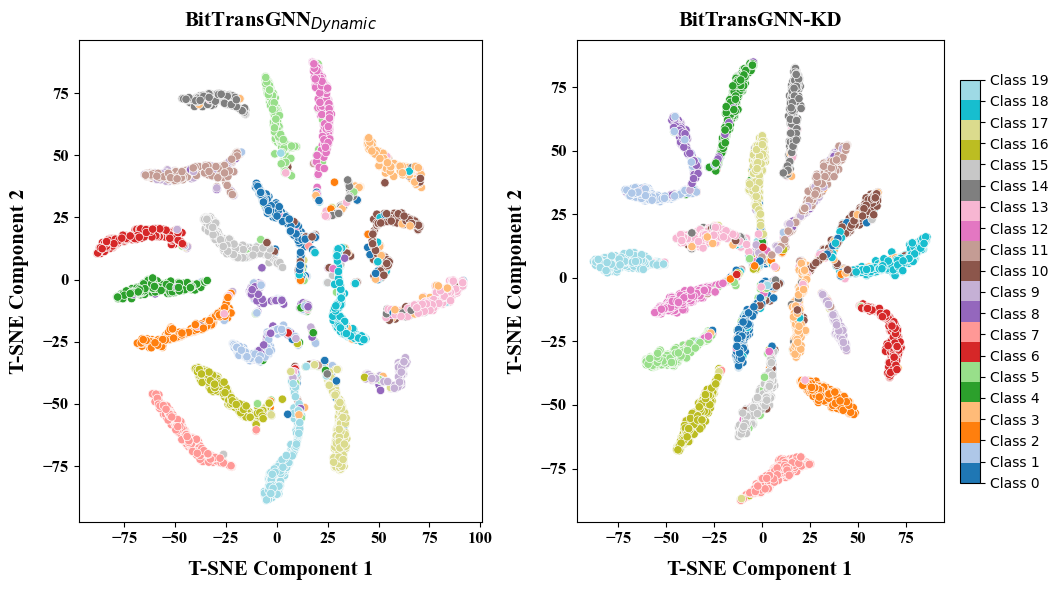

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap
import itertools
import numpy as np
import os

dataset_name = "20ng"
num_states_label = "1.0-bit"
method = method1 = "bitbertgcn"
train_type = train_type1 = "type4"
method2 = "KD"
train_type2 = "type4"
ckpt = ckpts[dataset_name][num_states_label][method][train_type]
ckpt1 = ckpts[dataset_name][num_states_label][method1][train_type1]
ckpt2 = ckpts[dataset_name][num_states_label][method2][train_type2]
y_labels = ckpt["test_logits"]["labels"]
num_classes = ckpt["test_logits"]["cls_logits"].shape[1]
print(num_classes)

embedding1 = ckpt1["tsne_embedding"]
embedding2 = ckpt2["tsne_embedding"]
print(embedding1.shape)
print(embedding2.shape)

class_labels = [f"class_{i}" for i in range(num_classes)]

#plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="viridis", s=10)
colors_list = plt.cm.tab20(np.linspace(0,1,num_classes))
selected_colors = colors_list[:num_classes]  # Pick first `num_classes` colors
custom_cmap = ListedColormap(selected_colors)  # Custom colormap with 2 colors

palette = selected_colors if num_classes < 20 else plt.cm.tab20(np.linspace(0,1,num_classes))

figure_size=6
plt.figure(figsize=(figure_size+4, figure_size))
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
#plt.grid(visible=True, axis="both")
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=embedding1[:, 0],
    y=embedding1[:, 1],
    hue=y_labels,
    palette=palette,
    legend=None
)
proj_method = "tsne"
if proj_method == "umap":
    proj_label = "UMAP"
elif proj_method == "tsne":
    proj_label = "T-SNE"
plt.xticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
plt.yticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
plt.title("BitTransGNN$_{Dynamic}$", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, pad=10)
plt.xlabel(f"{proj_label} Component 1", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
plt.ylabel(f"{proj_label} Component 2", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=embedding2[:, 0],
    y=embedding2[:, 1],
    hue=y_labels,
    palette=palette,
    legend=None
)
plt.title("BitTransGNN-KD", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, pad=10)
plt.xticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
plt.yticks(fontsize="12", fontweight="bold", fontfamily="times new roman")
plt.xlabel(f"{proj_label} Component 1", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
plt.ylabel(f"{proj_label} Component 2", fontdict={"family": "times new roman", "weight": "bold", "fontsize": 15}, labelpad=10)
plt.tight_layout()

norm = Normalize(vmin=0, vmax=num_classes - 1)  # Normalize for the full class range
if num_classes < 20:
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
else:
    sm = ScalarMappable(cmap=plt.cm.tab20, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable

# Add Colorbar
cbar = plt.colorbar(sm, ticks=np.arange(num_classes), fraction=0.05, pad=0.04)
#cbar.set_label("Class Indices", fontsize=12, fontweight="bold", fontfamily="times new roman", loc="center")
cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])  # Custom tick labels

save_path = f"{proj_method}_plots/{dataset_name}/{num_states_label}/{method1}_and_{method2}_{train_type}.pdf"        
print("save_path:", save_path)   
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, format="pdf", bbox_inches="tight")
plt.show()


PCA'DEN SONRASI, BURADAN SONRAKİLER KULLANIMA GEÇMEMİŞ DENEMELER, SONRA SİL!

In [8]:
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Example logits (num_samples, num_classes)
num_samples = 100
num_classes = 7
model1_logits = np.random.rand(num_samples, num_classes)
model2_logits = np.random.rand(num_samples, num_classes)

# Step 1: Compute mean logits for each class
model1_mean_logits = np.array([model1_logits[model1_logits.argmax(axis=1) == c].mean(axis=0) for c in range(num_classes)])
model2_mean_logits = np.array([model2_logits[model2_logits.argmax(axis=1) == c].mean(axis=0) for c in range(num_classes)])

# Step 2: Compute RSA (pairwise distances) for each model
# Use cosine similarity or Euclidean distance
model1_rsa = pairwise_distances(model1_mean_logits, metric="cosine")  # (num_classes, num_classes)
model2_rsa = pairwise_distances(model2_mean_logits, metric="cosine")

# Step 3: Stack the RSA matrices to compare models
rsa_combined = np.vstack([model1_rsa.flatten(), model2_rsa.flatten()])  # Combine the flattened RSA matrices

# Step 4: Apply PCA to the combined RSA matrices
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rsa_combined.T)  # Transpose to analyze (class pairs)


(100, 7)
(7, 7)
(7, 7)
(7, 7)
[[0.79638007 0.38177228 0.43242628 0.37953564 0.42166064 0.26019025
  0.46133554]
 [0.35848133 0.89704519 0.41442188 0.44562952 0.42774442 0.41429224
  0.43105845]
 [0.35464667 0.46744645 0.88113132 0.43592726 0.46496024 0.55995548
  0.34898612]
 [0.35771537 0.43367737 0.54255067 0.86309674 0.41784968 0.31998707
  0.50041198]
 [0.43621072 0.49443399 0.37284494 0.47668767 0.89329936 0.48693303
  0.49791451]
 [0.49512908 0.51022516 0.44894651 0.44116717 0.50347078 0.88719157
  0.39349577]
 [0.38099595 0.44299942 0.38165891 0.42149149 0.54877886 0.45382084
  0.85520498]]
[[0.         0.13978845 0.13944916 0.12564402 0.10897838 0.13162467
  0.10800858]
 [0.13978845 0.         0.11302396 0.11244008 0.09946866 0.09971129
  0.10781893]
 [0.13944916 0.11302396 0.         0.0988964  0.11782999 0.0780568
  0.13585266]
 [0.12564402 0.11244008 0.0988964  0.         0.1102542  0.13745019
  0.10100838]
 [0.10897838 0.09946866 0.11782999 0.1102542  0.         0.07984317


array([[0.        , 0.13978845, 0.13944916, 0.12564402, 0.10897838,
        0.13162467, 0.10800858],
       [0.13978845, 0.        , 0.11302396, 0.11244008, 0.09946866,
        0.09971129, 0.10781893],
       [0.13944916, 0.11302396, 0.        , 0.0988964 , 0.11782999,
        0.0780568 , 0.13585266],
       [0.12564402, 0.11244008, 0.0988964 , 0.        , 0.1102542 ,
        0.13745019, 0.10100838],
       [0.10897838, 0.09946866, 0.11782999, 0.1102542 , 0.        ,
        0.07984317, 0.06330867],
       [0.13162467, 0.09971129, 0.0780568 , 0.13745019, 0.07984317,
        0.        , 0.10531511],
       [0.10800858, 0.10781893, 0.13585266, 0.10100838, 0.06330867,
        0.10531511, 0.        ]])

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Example logits (num_samples, num_classes)
num_samples = 100
num_classes = 7
model1_logits = np.random.rand(num_samples, num_classes)
model2_logits = np.random.rand(num_samples, num_classes)

model1_rsa = pairwise_distances(model1_mean_logits, metric="cosine")  # (num_classes, num_classes)
model2_rsa = pairwise_distances(model2_mean_logits, metric="cosine")
importance_profiles = np.vstack([model1_rsa, model2_rsa])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(importance_profiles)

print(model1_logits.shape)
print(model1_mean_logits.shape)
print(model1_rsa.shape)
print(pairwise_distances(model1_logits.T, metric="cosine").shape)
print(model1_mean_logits)
print(model1_rsa)
pairwise_distances(model1_mean_logits, model1_mean_logits, metric="cosine")

In [ ]:
# %%
# correlation analysis

import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import pearsonr, spearmanr

num_samples = 100
num_classes = 7

# Example logits
teacher_logits = np.random.rand(num_samples, num_classes)  # Teacher logits (100 samples, 7 classes)
student_logits = np.random.rand(num_samples, num_classes)  # Student logits (100 samples, 7 classes)
teacher_probs = F.softmax(torch.tensor(teacher_logits), dim=1).numpy()
student_probs = F.softmax(torch.tensor(student_logits), dim=1).numpy()

# Compute correlations for each class
for i in range(teacher_logits.shape[1]):
    pearson_corr, _ = pearsonr(teacher_logits[:, i], student_logits[:, i])
    spearman_corr, _ = spearmanr(teacher_logits[:, i], student_logits[:, i])
    print(f"Class {i}: Pearson Corr = {pearson_corr:.2f}, Spearman Corr = {spearman_corr:.2f}")

# %%
# visualize correlation

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tensor1 = np.random.rand(100, 10)
tensor2 = np.random.rand(100, 10)

# Compute correlation matrix
corr_matrix = np.corrcoef(tensor1.flatten(), tensor2.flatten())

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# %%
# Heatmap of Differences: Visualize the differences in logits or probabilities across all classes

import seaborn as sns
import matplotlib.pyplot as plt

# Difference between teacher and student logits
diff_logits = teacher_logits - student_logits

# Heatmap
sns.heatmap(diff_logits, cmap="coolwarm", center=0)
plt.title("Difference Between Teacher and Student Logits")
plt.show()

# %%
# Scatter Plot: Compare teacher and student logits for individual classes

import matplotlib.pyplot as plt

for i in range(teacher_logits.shape[1]):
    plt.scatter(teacher_logits[:, i], student_logits[:, i], alpha=None, label=f"Class {i}")
plt.xlabel("Teacher Logits")
plt.ylabel("Student Logits")
plt.legend()
plt.title("Scatter Plot of Teacher vs Student Logits")
plt.show()

# %%
# c. Pairwise Correlation Matrix

import pandas as pd

# Create a DataFrame with logits or probabilities
data = {
    f"Teacher_Class_{i}": teacher_probs[:, i] for i in range(num_classes)
    #f"Teacher_Class_{i}": teacher_logits[:, i] for i in range(num_classes)
}
data.update({
    f"Student_Class_{i}": student_probs[:, i] for i in range(num_classes)
    #f"Student_Class_{i}": student_logits[:, i] for i in range(num_classes)
})
df = pd.DataFrame(data)

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap of the correlation matrix
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Matrix (Teacher vs. Student)")
plt.show()


# %%
# e. Confidence Difference Visualization

teacher_confidence = np.max(teacher_probs, axis=1)
student_confidence = np.max(student_probs, axis=1)
confidence_difference = teacher_confidence - student_confidence

# Plot histogram
plt.hist(confidence_difference, bins=20, color="purple", alpha=0.7)
plt.xlabel("Confidence Difference (Teacher - Student)")
plt.ylabel("Frequency")
plt.title("Confidence Level Differences")
plt.show()

# %%

# d. Agreement Metrics

teacher_preds = np.argmax(teacher_probs, axis=1)
student_preds = np.argmax(student_probs, axis=1)

# Calculate agreement
agreement = teacher_preds == student_preds

# Create data for agree and disagree
agree_data = teacher_preds[agreement]
disagree_data = teacher_preds[~agreement]

# Plot histogram
plt.hist([disagree_data, agree_data], bins=range(0, 8), color=["red", "blue"], alpha=0.7, label=["Disagree", "Agree"])
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Teacher vs. Student Agreement by Class")
plt.legend()
plt.show()

# %%

# Mutual information

from sklearn.metrics import mutual_info_score

# Flatten logits for mutual information
teacher_logits_flat = teacher_logits.flatten()
student_logits_flat = student_logits.flatten()

mi = mutual_info_score(teacher_logits_flat, student_logits_flat)
print(f"Mutual Information: {mi:.2f}")


# %%

# UMAP and T-SNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns

# Example teacher and student logits (replace with your actual data)
num_samples = 100
num_classes = 7

teacher_logits = np.random.randn(num_samples, num_classes)  # Replace with teacher's logits
student_logits = np.random.randn(num_samples, num_classes)  # Replace with student's logits

# Combine teacher and student logits
combined_logits = np.hstack((teacher_logits, student_logits))

# Labels for visualization (optional, e.g., true class labels)
true_labels = np.random.randint(0, num_classes, size=num_samples)  # Replace with ground truth

# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(combined_logits)

# Apply T-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embedding = tsne.fit_transform(combined_logits)

# Plot UMAP embedding
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=umap_embedding[:, 0],
    y=umap_embedding[:, 1],
    hue=true_labels,
    palette="viridis",
    legend="full"
)
plt.title("UMAP Embedding")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Plot T-SNE embedding
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=tsne_embedding[:, 0],
    y=tsne_embedding[:, 1],
    hue=true_labels,
    palette="viridis",
    legend="full"
)
plt.title("T-SNE Embedding")
plt.xlabel("T-SNE1")
plt.ylabel("T-SNE2")

plt.tight_layout()
plt.show()

# %%

# PCA

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Example: Random logits data (replace with actual logits from your models)
num_samples = 100
num_classes = 7

logits_model1 = np.random.rand(num_samples, num_classes)  # Replace with actual logits
logits_model2 = np.random.rand(num_samples, num_classes)  # Replace with actual logits

# Concatenate logits for PCA
logits_combined = np.vstack([logits_model1, logits_model2])  # Shape: (2*num_samples, num_classes)

# Standardize the data (important for PCA)
scaler = StandardScaler()
logits_combined_scaled = scaler.fit_transform(logits_combined)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(logits_combined_scaled)

# Separate the PCA-transformed logits by model
pca_model1 = pca_result[:num_samples]
pca_model2 = pca_result[num_samples:]

# Explained variance ratio
print("Explained variance by components:", pca.explained_variance_ratio_)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_model1[:, 0], pca_model1[:, 1], label="Model 1", alpha=0.7, color="blue")
plt.scatter(pca_model2[:, 0], pca_model2[:, 1], label="Model 2", alpha=0.7, color="red")
plt.title("PCA Analysis of Model Logits")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

# Example: Random class labels
class_labels = np.random.randint(0, num_classes, num_samples)

plt.figure(figsize=(8, 6))
plt.scatter(pca_model1[:, 0], pca_model1[:, 1], c=class_labels, cmap="viridis", label="Model 1", alpha=0.7)
plt.scatter(pca_model2[:, 0], pca_model2[:, 1], c=class_labels, cmap="viridis", label="Model 2", alpha=0.7, marker="x")
plt.title("PCA Analysis of Model Logits (Colored by Class)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class")
plt.legend()
plt.grid()
plt.show()

